In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from dask import compute, delayed
from matplotlib import pyplot as plt
%matplotlib inline
import xrft
from mitequinox.utils import *

import cartopy.crs as ccrs
from cmocean import cm

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(17)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.6:54219 Dashboard: http://10.148.1.6:8787/status,Cluster Workers: 34 Cores: 136 Memory: 1700.00 GB


# Read SSU nc_dataset

_____


In [65]:
### Here we need to load both SSU and SSV to generate the complex format of horizontal velocoty for rotary spectral calculations, u+iv

v_u = 'SSU'

## data files (SSU,SSV) ##
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC1080/'

print(data_dir)

/home1/scratch/xyu/mit_zarr/UV/LLC1080/


## Grid

### LLC1080

In [66]:
# grid file
mgrid = xr.open_dataset('/home1/datawork/xyu/grid/mit_grid_t_1080.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','dxG','dyG','dxC','dyC','rAw','rAs','rAz'])
print(mgrid)

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, i, j) float32 ...
    YC       (face, i, j) float32 ...
    CS       (face, i, j) float32 ...
    SN       (face, i, j) float32 ...
    rA       (face, i, j) float32 ...
    Depth    (face, i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


In [67]:
grid = mgrid.isel(face=1)
## Here we do DFT on u+iv ##
time_chunk = 1440
ij_chunk = 108

# Read SSU #
ds_SSU = xr.open_zarr(data_dir+'SSU_f01.zarr').rename({'i_g': 'i'})
chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (2 months)
ds_SSU = ds_SSU.chunk(chunks) 
ds = xr.merge([ds_SSU, grid])    
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (i: 1080, j: 1080, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
    face     int64 1
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    CS       (i, j) float32 ...
    SN       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    SSU      (time, j, i) float32 dask.array<shape=(8640, 1080, 1080), chunksize=(1440, 108, 108)>

 data size: 40.3 GB


In [69]:
E = ds.SSU
E_mean = E.isel(i=slice(0,100), j=slice(0,100)).mean(dim=['i','j'])
chunks={'time': 1440} # time chunck: (2 months)
E_mean = E_mean.chunk(chunks) 
E_mean_fft = xrft.dft(E_mean.fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=True)
E_eta1 = (E_mean_fft*E_mean_fft.conj()).where(E_mean_fft!=0., drop=False)
E_u = E_eta1.mean(dim=['time_segment']).load()
E_u = E_u.astype('f8').rename('Eta_power_spectrum ()')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/ops.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
  return method(*args, **kwargs)


No handles with labels found to put in legend.


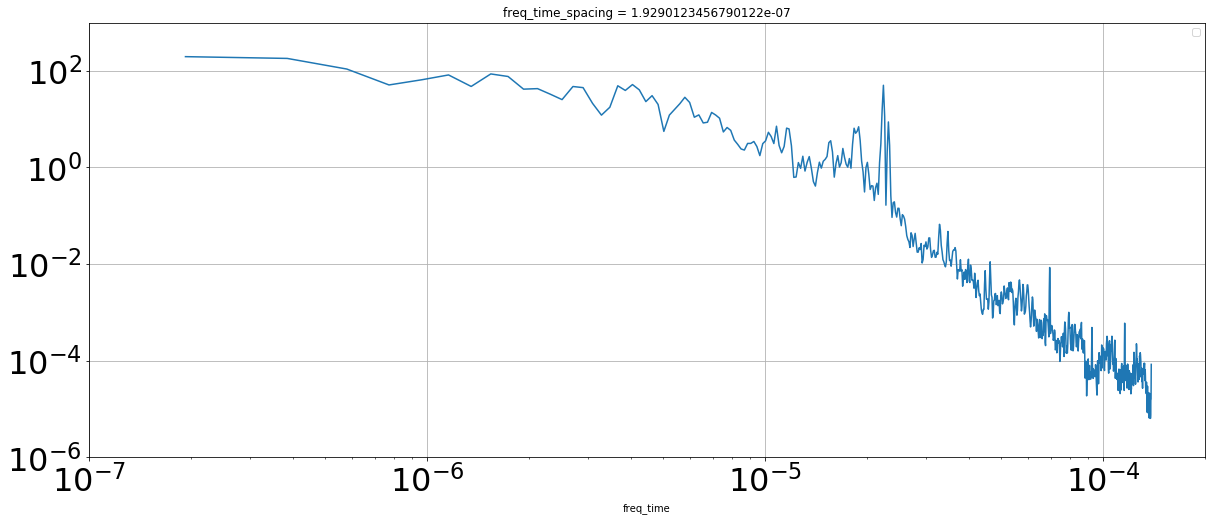

In [70]:
fig, ax = plt.subplots(figsize=(20,8))
E_u.where(E_u.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
ax.set_xlim([1e-7,2*1e-4])
ax.set_ylim([1e-6,1e3])
# M2 #
#ax.plot([1/12.42/3600,1/12.42/3600],[1e-2,1e6],'k--') 
#ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'r--') 
#ax.plot([1/12.58/3600,1/12.58/3600],[1e-2,1e6],'b--') 
# K1 #
#ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')
#ax.plot([1/25.81/3600,1/25.81/3600],[1e-2,1e6],'k--')

ax.tick_params(labelsize=32)

# Uncertainties

In [71]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%
import h5py

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'

drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
list(drifter_dataset.items())

[('dpth2', <HDF5 dataset "dpth2": shape (157978, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (157978, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (157978, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (157978, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (157978, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (157978, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (157978, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (157978, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (157978, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (157978, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (157978, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (157978, 1), type "|u1">),
 ('u2_err', <HDF5 dataset "u2_err": shape (157978, 1440), type "<f8">),
 ('uv2', <HDF5 dataset "uv2": shape (157978, 1440), type "|V16">),
 ('v2_err', <HDF5 dataset "v2_err": sh

In [72]:
# turn mean-lat into xarray_DataArray
u2_err = drifter_dataset['u2_err']
u2_err = np.array(u2_err)

In [73]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 157978)>
array([ 44.219853,  44.908928,  44.856863, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [74]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'u2_err': (['lat', 'time'], u2_err)},
                 coords={'lat': (['lat'], lat),
                         'time':(['time'], np.arange(1440)*3600)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (lat: 157978, time: 1440)
Coordinates:
  * lat      (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 46.08 45.38 ...
  * time     (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...
Data variables:
    u2_err   (lat, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

 data size: 1.8 GB


<xarray.DataArray 'u2_err' (time: 1440)>
array([0.057 , 0.0517, 0.0625, ..., 0.0788, 0.1903, 0.1076])
Coordinates:
    lat      float64 -40.89
  * time     (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...


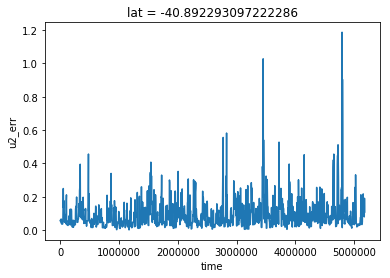

In [75]:
E_err = ds.u2_err.isel(lat=1000)
E_err.plot()
print(E_err)

In [76]:
E_err_fft = xrft.dft(E_err.fillna(0.), dim=['time'], shift=False, detrend='linear', window=True)
E_err = (E_err_fft*E_err_fft.conj()).where(E_err_fft!=0., drop=False)
E_err = E_err.astype('f8').rename('Eta_power_spectrum ()')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/ops.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
  return method(*args, **kwargs)


No handles with labels found to put in legend.


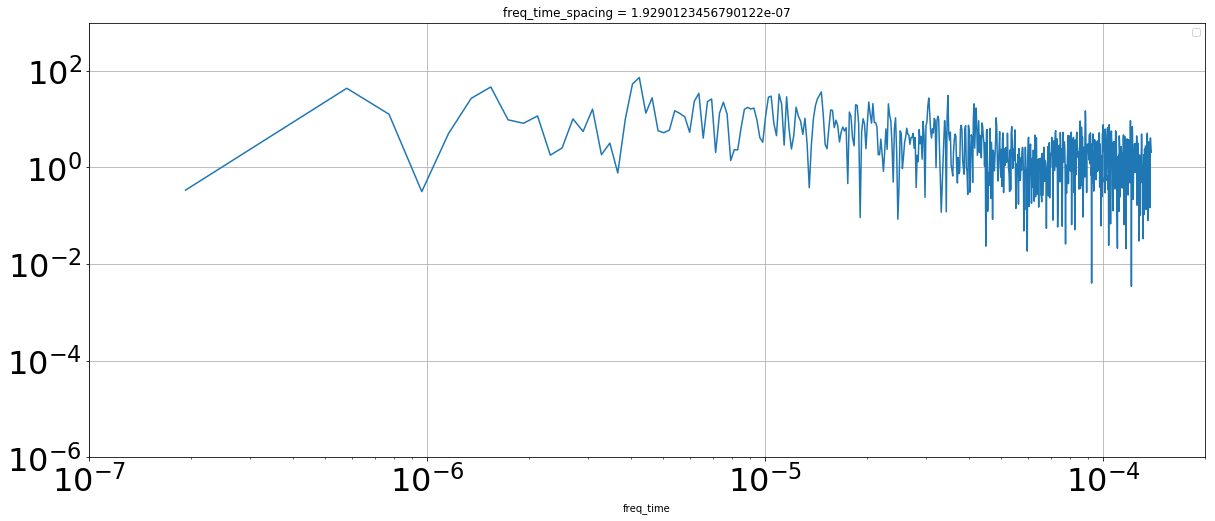

In [77]:
fig, ax = plt.subplots(figsize=(20,8))
E_err.where(E_err.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
ax.set_xlim([1e-7,2*1e-4])
ax.set_ylim([1e-6,1e3])
# 

ax.tick_params(labelsize=32)

No handles with labels found to put in legend.


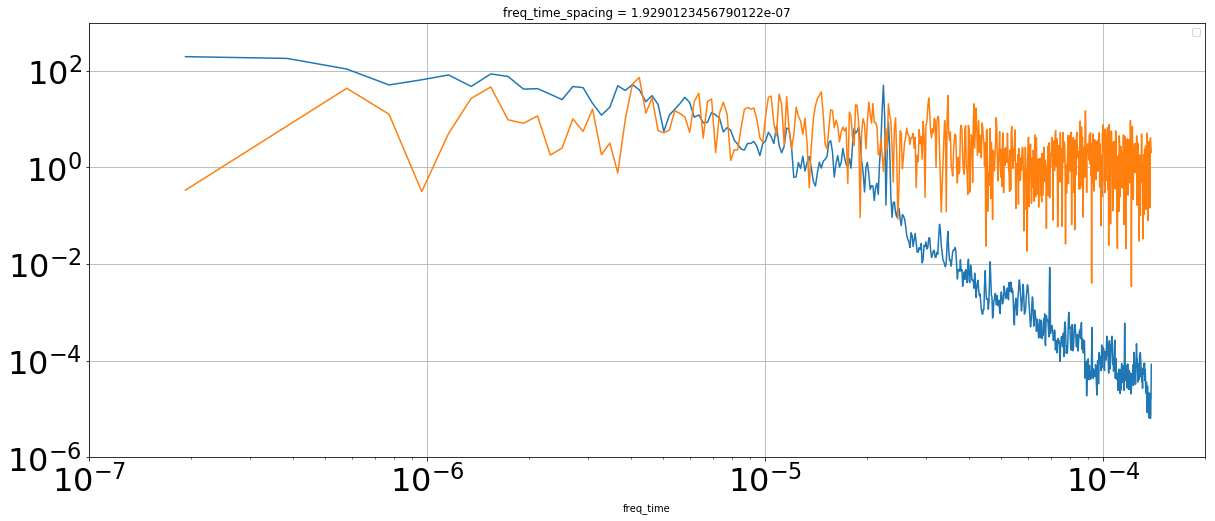

In [78]:
fig, ax = plt.subplots(figsize=(20,8))
E_u.where(E_u.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
ax.set_xlim([1e-7,2*1e-4])
ax.set_ylim([1e-6,1e3])
# M2 #
E_err.where(E_err.freq_time>0).plot(ax=ax)

ax.tick_params(labelsize=32)

# Combined

In [42]:
E = ds.SSU
E_mean = E.isel(i=slice(0,100), j=slice(0,100)).mean(dim=['i','j'])
chunks={'time': 1440} # time chunck: (2 months)
E_mean = E_mean.chunk(chunks) 
E_mean_fft = xrft.dft(E_mean.fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=True)
E_eta1 = (E_mean_fft*E_mean_fft.conj()).where(E_mean_fft!=0., drop=False)
E_u = E_eta1.mean(dim=['time_segment']).load()
E_u = E_u.astype('f8').rename('Eta_power_spectrum ()')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/ops.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
  return method(*args, **kwargs)


In [ ]:
ds.u2_err.isel(lat=1000)

In [55]:
E_mean = E.isel(i=slice(0,100), j=slice(0,100), time=slice(0,1440)).mean(dim=['i','j'])
print(E_mean)

<xarray.DataArray 'SSU' (time: 1440)>
dask.array<shape=(1440,), dtype=float32, chunksize=(1440,)>
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(1440,), chunksize=(1440,)>
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...


In [56]:
E_mean_err = E_mean + ds.u2_err.isel(lat=1000)

In [58]:
a = ds.u2_err.isel(lat=1000)
print(a)

<xarray.DataArray 'u2_err' (time: 1440)>
array([0.057 , 0.0517, 0.0625, ..., 0.0788, 0.1903, 0.1076])
Coordinates:
    lat      float64 -40.89
  * time     (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...


In [82]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(0, E_err, 1000)
print(s)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

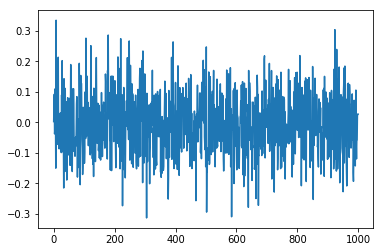

In [81]:
plt.plot(s)